In [1]:
from phi.torch.flow import *
import sys
sys.path.append('..')
from tqdm.notebook import trange
import warp
import nvdiffrast.torch as dr

In [2]:
import warp
backend.default_backend().set_default_device('GPU')
torch.set_default_device('cuda')

In [3]:
# fluid specification & initialization
# TODO: integrate resolutions, bounds into one parameter
RES_X = 128  
RES_Y = 64
BOUND_X = 200
BOUND_Y = 100
NUM_TIME_STEPS = 1001
DT = 0.5
domain = Box(x=BOUND_X, y=BOUND_Y)
INFLOW_RATE = 0.5
BUOYANCY = 0.1
inflow = Sphere(x=BOUND_X/2, y=9.5, radius=8)

v0 = StaggeredGrid(0, 0, domain, x=RES_X, y=RES_Y)
smoke0 = CenteredGrid(0, math.extrapolation.BOUNDARY, domain, x=RES_X, y=RES_Y)

In [4]:
# fluid step function with smoke inflow
@jit_compile
def step(v, s, p, dt, viscosity=0.1):
    s = advect.mac_cormack(s, v, dt) + INFLOW_RATE * resample(inflow, to=s, soft=True)
    buoyancy = resample(s * (0, BUOYANCY), to=v)
    v = advect.semi_lagrangian(v, v, dt) + buoyancy * dt
    v = diffuse.explicit(v, viscosity, dt)
    v, p = fluid.make_incompressible(v, (), Solve('CG', 1e-3, x0=p))
    return v, s, p

In [5]:
obs = field.CenteredGrid(0, math.extrapolation.BOUNDARY, domain, x=RES_X, y=RES_Y)

In [6]:
v_trj, s_trj, p_trj = iterate(step, batch(time=NUM_TIME_STEPS), v0, smoke0, None, dt=DT, range=trange, substeps=3)

  0%|          | 0/1001 [00:00<?, ?it/s]

/home/xinluo/anaconda3/envs/ACDM-warp/lib/python3.10/site-packages/torch/utils/_device.py:79: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  return func(*args, **kwargs)


In [7]:
# cancel initial dummy values
v_trj = v_trj.time[1:NUM_TIME_STEPS+1].at_centers()
s_trj = s_trj.time[1:NUM_TIME_STEPS+1]

In [8]:
NUM_PLOT_SKIP = 10
NUM_PLOT_FRAMES = int(NUM_TIME_STEPS / NUM_PLOT_SKIP)

In [9]:
DOWN_FACTOR = 16
RES_X_DOWN = int(RES_X / DOWN_FACTOR)
RES_Y_DOWN = int(RES_Y / DOWN_FACTOR)
grid_down = field.CenteredGrid(0,math.extrapolation.ZERO_GRADIENT,domain, x=RES_X_DOWN, y=RES_Y_DOWN)
vel_trj_down = field.resample(value=v_trj, to=grid_down)
dens_trj_down = field.resample(value=s_trj, to=grid_down)
pres_trj_down = field.resample(value=p_trj, to=grid_down)
obs_down = field.resample(value=obs, to= grid_down)

In [10]:
vis.plot({'dens':s_trj.time[0:NUM_TIME_STEPS:NUM_PLOT_SKIP], 'dens down sampling':dens_trj_down.time[0:NUM_TIME_STEPS:NUM_PLOT_SKIP]}, animate='time', frame_time=100)

<Figure size 1200x500 with 4 Axes>

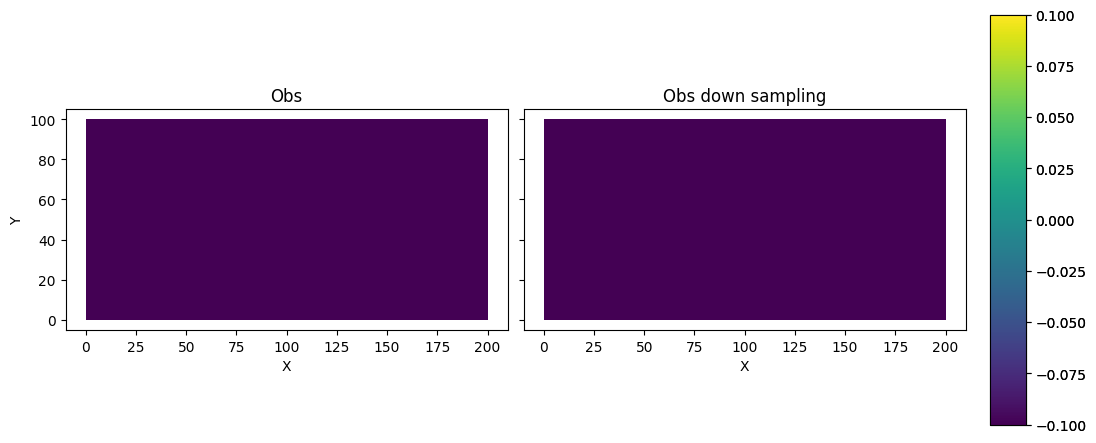

In [11]:
vis.plot({'obs': obs, 'obs down sampling':obs_down})

In [12]:
v_x_mean = math.mean(math.rename_dims(v_trj.values.vector['x'],dims='time', names=math.instance(time=NUM_TIME_STEPS)))
v_y_mean = math.mean(math.rename_dims(v_trj.values.vector['y'],dims='time', names=math.instance(time=NUM_TIME_STEPS)))
d_mean = math.mean(math.rename_dims(s_trj.values,dims='time', names=math.instance(time=NUM_TIME_STEPS)))
p_mean = math.mean(math.rename_dims(p_trj.values,dims='time', names=math.instance(time=NUM_TIME_STEPS)))

In [13]:
(v_x_mean,v_y_mean,d_mean,p_mean)

(1.2897889e-05,
 1.7301423e-06,
 8.793167,
 7.675125e-06)

In [17]:
v_x_std = math.std(math.rename_dims(v_trj.values.vector['x'],dims='time', names=math.instance(time=NUM_TIME_STEPS)))
v_y_std = math.std(math.rename_dims(v_trj.values.vector['y'],dims='time', names=math.instance(time=NUM_TIME_STEPS)))
d_std = math.std(math.rename_dims(s_trj.values,dims='time', names=math.instance(time=NUM_TIME_STEPS)))
p_std = math.std(math.rename_dims(p_trj.values,dims='time', names=math.instance(time=NUM_TIME_STEPS)))

In [18]:
(v_x_std,v_y_std,d_std,p_std)

(0.9211658,
 1.0428805,
 5.2929244,
 14.740474)

In [15]:
scene = field.Scene.create("./data/128_slow_plum", name="sim")

for f in range(NUM_TIME_STEPS):
    scene.write_field(field=v_trj.time[f], name='velocity',frame=f)
    scene.write_field(field=math.expand(s_trj.time[f],math.channel(vector=1)),name='density', frame=f)
    scene.write_field(field=math.expand(p_trj.time[f],math.channel(vector=1)),name='pressure', frame=f)
scene.write_field(field=obs_down,name='obstacle_mask',frame=0)

/home/xinluo/anaconda3/envs/ACDM-warp/lib/python3.10/site-packages/phi/field/_scene.py:150: RuntimeWarning: Failed to copy calling script to scene during Scene.create(): [Errno 2] No such file or directory: '/tmp/ipykernel_122811/3514933668.py'
  warnings.warn(f"Failed to copy calling script to scene during Scene.create(): {err}", RuntimeWarning)


In [16]:
scene = field.Scene.create("./data/128_slow_plum_down_16", name="sim")

for f in range(NUM_TIME_STEPS):
    scene.write_field(field=vel_trj_down.time[f], name='velocity',frame=f)
    scene.write_field(field=math.expand(dens_trj_down.time[f],math.channel(vector=1)),name='density', frame=f)
    scene.write_field(field=math.expand(pres_trj_down.time[f],math.channel(vector=1)),name='pressure', frame=f)
scene.write_field(field=obs_down,name='obstacle_mask',frame=0)

/home/xinluo/anaconda3/envs/ACDM-warp/lib/python3.10/site-packages/phi/field/_scene.py:150: RuntimeWarning: Failed to copy calling script to scene during Scene.create(): [Errno 2] No such file or directory: '/tmp/ipykernel_122811/1304963270.py'
  warnings.warn(f"Failed to copy calling script to scene during Scene.create(): {err}", RuntimeWarning)
